 **Dynamic Triangulation-Based Graph Rewiring for Graph Neural Networks**


---

# Here is a simple notebook to reproduce our experiments

---
The entire code will be available on GitHub.


In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.6.0+cu124
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.datasets import Planetoid, Amazon,WebKB,HeterophilousGraphDataset,WikipediaNetwork,CitationFull,Actor
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import homophily,add_self_loops, is_undirected,to_networkx,from_networkx,to_undirected, to_dense_adj, dense_to_sparse,contains_self_loops
import time


#dataset = Planetoid(root='data/Planetoid', name='cora')#, transform=NormalizeFeatures())
#dataset = Amazon(root='data/amazon', name='photo', transform=NormalizeFeatures())#
#dataset = WebKB(root='data/', name='Cornell',transform = NormalizeFeatures())#TEXAS/WISCONSIN/CORNELL
#dataset = CitationFull(root='data/Citeseer', name='Citeseer', to_undirected = False)#
dataset = WikipediaNetwork(root='data/WikipediaNetwork', name='chameleon')#CHAMELEON/SQUIRELL
#dataset = HeterophilousGraphDataset(root='data/Roman-Empire', name='Roman-Empire')
#dataset = Actor(root='data/Actor')#ACTOR
#dataset = Twitch(root='data/twitch',name='DE')
#dataset = DeezerEurope(root='data/DeezerEurope')
#dataset = Flickr(root='data/Flickr')
#dataset =  LINKXDataset(root='data/LINKXDataset',name='genius')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')


print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

data_und = to_undirected(data.edge_index)
#data_und,_= add_self_loops(data_und, num_nodes=data.num_nodes)


Dataset: WikipediaNetwork():
Number of graphs: 1
Number of features: 2325
Number of classes: 5

Data(x=[2277, 2325], edge_index=[2, 36101], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10])
Number of nodes: 2277
Number of edges: 36101
Average node degree: 15.85
Number of training nodes: 10920
Training node label rate: 4.80
Has isolated nodes: False
Has self-loops: True
Is undirected: False


We retrieve the rewired graphs derived from Delaunay triangulation (Delaunay Graph: Addressing Over-Squashing and Over-Smoothing Using Delaunay Triangulation, Attali et al., ICML 2024).

In [4]:
import pickle
from torch_geometric.data import Data

AA = open('.../chameleon_DR.pk','rb')
delaunay = pickle.load(AA)

tri = Data(**{k: v for k, v in data.items() if k != 'edge_index'})
tri.edge_index = delaunay


In [5]:
import networkx as nx

def extract_triangles(edge_index):
    G = to_networkx(Data(edge_index=edge_index), to_undirected=True)
    triangles = [list(clique) for clique in nx.find_cliques(G) if len(clique) == 3]
    return triangles

def compute_triangle_features_and_labels(triangles, node_features, labels, train_mask):
    features = []
    triangle_labels = []

    for tri in triangles:
        i, j, k = tri
        feat_tri = torch.cat([node_features[i], node_features[j], node_features[k]])
        features.append(feat_tri)

        if train_mask is not None and not (train_mask[i] and train_mask[j] and train_mask[k]):
            triangle_labels.append(0)
        else:
            label_i, label_j, label_k = labels[i].item(), labels[j].item(), labels[k].item()
            unique_labels = set([label_i, label_j, label_k])

            if len(unique_labels) <= 2:
                triangle_labels.append(1)
            else:
                triangle_labels.append(0)

    if not features:
        return torch.empty(0, node_features.shape[1] * 3, device=device), torch.empty(0, device=device)

    return torch.stack(features), torch.tensor(triangle_labels, dtype=torch.float, device=device)


In [6]:
from sklearn.neighbors import kneighbors_graph

def knn_graph(x, k=10):
    #Creates a graph based on k-nearest neighbors
    adj = kneighbors_graph(x.cpu().numpy(), k, mode='connectivity', include_self=False)
    edge_index = dense_to_sparse(torch.tensor(adj.todense(), dtype=torch.float).to(x.device))[0]
    return to_undirected(edge_index)

KNNG = knn_graph(data.x,k=10)

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.utils import to_undirected
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.data import Data
import numpy as np

# === Device setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
nb_runs =1
S = []
# === Contrastive Loss ===
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, preds, targets):
        pos_loss = (1 - targets) * torch.pow(preds, 2)
        neg_loss = targets * torch.pow(torch.clamp(self.margin - preds, min=0.0), 2)
        return (pos_loss + neg_loss).mean()

class TriangleMLP(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim=64, out_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(node_feature_dim * 3, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)

    def forward(self, triangle_features):
        x = F.relu(self.bn1(self.fc1(triangle_features)))
        x = F.relu(self.bn2(self.fc2(x)))
        return x

# === Triangle Selector ===
class TriangleSelector(nn.Module):
    def __init__(self, input_dim,num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)
        self.fc5 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.5)
        self.tau = nn.Parameter(torch.tensor(1.0))
        self.pi = nn.Parameter(torch.arange(1, num_classes + 1, device=device, dtype=torch.float32) * 6)


    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        logits = self.fc5(x)
        tau = F.softplus(self.tau)
        probs = F.gumbel_softmax(logits, tau=tau, hard=True)
        return probs[:, 1], tau

    def triangle_participation_loss(self, selected_triangles, node_labels, train_mask):
        triangle_counts = torch.zeros_like(node_labels, dtype=torch.float, device=node_labels.device)
        for i, j, k in selected_triangles:
            if train_mask[i] and train_mask[j] and train_mask[k]:
                triangle_counts[i] += 1
                triangle_counts[j] += 1
                triangle_counts[k] += 1

        targets = self.pi[node_labels]
        mask = train_mask
        return F.mse_loss(triangle_counts[mask], targets[mask])

# === GCN ===
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.dropout = dropout
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x,x

# === Structural Loss ===
def structural_loss(selected_triangles, node_features, train_mask):
    if len(selected_triangles) == 0:
        return torch.tensor(0.0, device=node_features.device)
    selected_triangles = torch.tensor(selected_triangles, dtype=torch.long, device=node_features.device)
    selected_mask = train_mask[selected_triangles[:, 0]] & train_mask[selected_triangles[:, 1]] & train_mask[selected_triangles[:, 2]]
    selected_triangles = selected_triangles[selected_mask]
    x_i = node_features[selected_triangles[:, 0]]
    x_j = node_features[selected_triangles[:, 1]]
    x_k = node_features[selected_triangles[:, 2]]
    return (torch.norm(x_i - x_j, dim=1).mean() +
            torch.norm(x_j - x_k, dim=1).mean() +
            torch.norm(x_k - x_i, dim=1).mean())

# === Train pipeline ===
def train_pipeline(edge_index_original, edge_index_delaunay, edge_index_KNN,
                   node_features, labels, patience=100):
    node_features, labels = node_features.to(device), labels.to(device)
    edge_index_original = edge_index_original.to(device)
    edge_index_delaunay = edge_index_delaunay.to(device)
    edge_index_KNN = edge_index_KNN.to(device)

    shuffled = torch.randperm(len(labels))
    train_mask = torch.zeros(len(labels), dtype=torch.bool, device=device)
    val_mask = torch.zeros(len(labels), dtype=torch.bool, device=device)
    test_mask = torch.zeros(len(labels), dtype=torch.bool, device=device)
    train_mask[shuffled[:int(0.6*len(labels))]] = True
    val_mask[shuffled[int(0.6*len(labels)):int(0.8*len(labels))]] = True
    test_mask[shuffled[int(0.8*len(labels)):]] = True

    triangles = extract_triangles(edge_index_original) + \
                extract_triangles(edge_index_delaunay) + \
                extract_triangles(edge_index_KNN)

    features, triangle_labels = compute_triangle_features_and_labels(triangles, node_features, labels)
    features, triangle_labels = features.to(device), triangle_labels.to(device)

    triangle_mlp = TriangleMLP(node_features.size(1), hidden_dim=256, out_dim=256).to(device)
    triangle_selector = TriangleSelector(256, num_classes=labels.max().item() + 1).to(device)
    gcn = GCN(node_features.size(1), 48, labels.max().item() + 1,num_layers=2).to(device)


    opt_mlp = optim.Adam(list(triangle_mlp.parameters()), lr=0.01, weight_decay=5e-6)
    opt_sel = optim.Adam(triangle_selector.parameters(), lr=0.01, weight_decay=5e-6)
    opt_gcn = optim.Adam(gcn.parameters(), lr=0.005, weight_decay=5e-5)

    contrastive_loss = ContrastiveLoss()
    cross_entropy = nn.CrossEntropyLoss()

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(1000):
        opt_mlp.zero_grad()
        opt_sel.zero_grad()

        triangle_features_transformed = triangle_mlp(features)
        preds, tau = triangle_selector(triangle_features_transformed)
        loss_mlp = contrastive_loss(preds, triangle_labels)

        selected = preds > 0.5
        selected_triangles = [tri for tri, keep in zip(triangles, selected.cpu()) if keep.item()]

        with torch.no_grad():
            _, x2 = gcn(node_features, edge_index_original)

        loss_struct = structural_loss(selected_triangles, x2, train_mask)
        loss_participation = triangle_selector.triangle_participation_loss(selected_triangles, labels, train_mask)

        total_loss = loss_mlp + loss_participation +  loss_struct

        total_loss.backward()
        opt_mlp.step()
        opt_sel.step()

        # Rebuild edge_index
        edge_set = set()
        for i, j, k in selected_triangles:
            edge_set.update([(i, j), (j, k), (k, i)])
        edge_index_final = torch.tensor(list(edge_set), dtype=torch.long, device=device).T
        edge_index_final = to_undirected(edge_index_final)

        # Train GCN
        opt_gcn.zero_grad()
        logits, _ = gcn(node_features, edge_index_final)
        loss_gcn = cross_entropy(logits[train_mask], labels[train_mask])
        loss_gcn.backward()
        opt_gcn.step()

        val_acc = (logits[val_mask].argmax(dim=1) == labels[val_mask]).float().mean().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = (logits[test_mask].argmax(dim=1) == labels[test_mask]).float().mean().item()
            patience_counter = 0
        else:
            patience_counter += 1

        print(f"Epoch {epoch:03d} | Val Acc: {val_acc:.4f} | Test Acc: {best_test_acc:.4f}")

        if patience_counter >= patience:
            S.append(best_test_acc)
            break

    return edge_index_final, best_test_acc

for i in range(nb_runs):
    Trigon, final_test_accuracy = train_pipeline(data_und, tri.edge_index, KNNG, data.x, data.y)
    S.append(final_test_accuracy)

print("Test Accuracies:", S)
print("Mean Test Accuracy:", np.mean(S))


Using device: cuda
Epoch 000 | Val Acc: 0.2198 | Test Acc: 0.1689
Epoch 001 | Val Acc: 0.4132 | Test Acc: 0.4035
Epoch 002 | Val Acc: 0.3868 | Test Acc: 0.4035
Epoch 003 | Val Acc: 0.4176 | Test Acc: 0.4189
Epoch 004 | Val Acc: 0.4330 | Test Acc: 0.4298
Epoch 005 | Val Acc: 0.4418 | Test Acc: 0.4649
Epoch 006 | Val Acc: 0.4791 | Test Acc: 0.4737
Epoch 007 | Val Acc: 0.5319 | Test Acc: 0.5110
Epoch 008 | Val Acc: 0.5648 | Test Acc: 0.5373
Epoch 009 | Val Acc: 0.6088 | Test Acc: 0.5680
Epoch 010 | Val Acc: 0.6088 | Test Acc: 0.5680
Epoch 011 | Val Acc: 0.6132 | Test Acc: 0.5877
Epoch 012 | Val Acc: 0.6176 | Test Acc: 0.5921
Epoch 013 | Val Acc: 0.6242 | Test Acc: 0.6184
Epoch 014 | Val Acc: 0.6505 | Test Acc: 0.6228
Epoch 015 | Val Acc: 0.6484 | Test Acc: 0.6228
Epoch 016 | Val Acc: 0.6769 | Test Acc: 0.6579
Epoch 017 | Val Acc: 0.6901 | Test Acc: 0.6776
Epoch 018 | Val Acc: 0.6725 | Test Acc: 0.6776
Epoch 019 | Val Acc: 0.7121 | Test Acc: 0.6886
Epoch 020 | Val Acc: 0.6923 | Test Acc: 0

In [37]:
import torch
import numpy as np
import networkx as nx
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

def cheeger_bound_chung(lambda2):
    return lambda2 / 2

def normalized_laplacian_matrix(G):
    A = nx.adjacency_matrix(G).astype(float)
    d = np.array(A.sum(axis=1)).flatten()
    d_sqrt_inv = 1.0 / np.sqrt(d)
    d_sqrt_inv[np.isinf(d_sqrt_inv)] = 0.0
    D_inv_sqrt = sp.diags(d_sqrt_inv)
    L = sp.identity(G.number_of_nodes()) - D_inv_sqrt @ A @ D_inv_sqrt
    return L

def compute_lambda2(L):
    vals = spla.eigsh(L, k=2, which='SM', return_eigenvectors=False)
    return sorted(vals)[1]

def compare_spectralgap_from_edge_index(edge_index: torch.LongTensor):
    num_nodes = int(edge_index.max()) + 1
    data = Data(edge_index=edge_index, num_nodes=num_nodes)

    G_full = to_networkx(data, to_undirected=True, remove_self_loops=True)

    if not nx.is_connected(G_full):
        largest_cc_nodes = max(nx.connected_components(G_full), key=len)
        G = G_full.subgraph(largest_cc_nodes).copy()
    else:
        G = G_full

    diameter = nx.diameter(G)
    T = sum(nx.triangles(G).values()) // 3
    n = G.number_of_nodes()
    d_max = max(dict(G.degree()).values())

    L = normalized_laplacian_matrix(G)
    lambda2 = compute_lambda2(L)

    print(f"Maximum degree d_max: {d_max}")
    print(f"Number of triangles T: {T}")
    print(f"λ₂ (eigenvalue): {lambda2:.4f}")
    print(f"Graph diameter: {diameter}")


In [38]:
print('Delaunay graph chameleon')
compare_spectralgap_from_edge_index(tri.edge_index)

Delaunay graph chameleon
Maximum degree d_max: 15
Number of triangles T: 4644
λ₂ (eigenvalue): 0.0020
Graph diameter: 21


In [39]:
print('Trigon graph chameleon')
compare_spectralgap_from_edge_index(Trigon)

Trigon graph chameleon
Maximum degree d_max: 135
Number of triangles T: 13786
λ₂ (eigenvalue): 0.0273
Graph diameter: 10


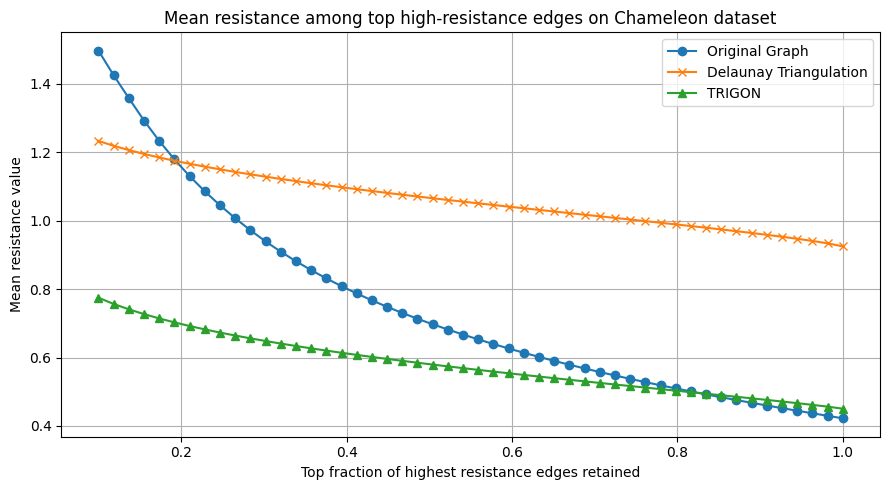

Graph saved as: resistance_top_deciles.png


In [36]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def extract_largest_connected_component(edge_index, num_nodes):
    G = nx.Graph()
    edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
    G.add_edges_from(edges)

    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc).copy()
        mapping = {old: new for new, old in enumerate(subgraph.nodes())}
        subgraph = nx.relabel_nodes(subgraph, mapping)
        new_edge_index = torch.tensor(list(subgraph.edges()), dtype=torch.long).t().contiguous()
        return new_edge_index, subgraph.number_of_nodes()
    else:
        return edge_index, num_nodes

def compute_resistance_matrix(edge_index, num_nodes):
    G = nx.Graph()
    edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
    G.add_edges_from(edges)

    resistance_dict = nx.resistance_distance(G, weight=None)
    resistance_matrix_np = np.zeros((num_nodes, num_nodes))

    for u, neighbors in resistance_dict.items():
        for v, R_uv in neighbors.items():
            resistance_matrix_np[u, v] = R_uv
            resistance_matrix_np[v, u] = R_uv

    return torch.tensor(resistance_matrix_np, dtype=torch.float32)

def compute_top_resistance_curve(edge_index, num_nodes, top_fractions):
    edge_index, num_nodes = extract_largest_connected_component(edge_index, num_nodes)
    R = compute_resistance_matrix(edge_index, num_nodes)
    triu_indices = torch.triu_indices(num_nodes, num_nodes, offset=1)
    resistance_values = R[triu_indices[0], triu_indices[1]]
    resistance_values = resistance_values[resistance_values > 0]

    sorted_vals = torch.sort(resistance_values, descending=True).values
    N = len(sorted_vals)

    means = []
    for f in top_fractions:
        k = max(int(N * f), 1)
        selected = sorted_vals[:k]
        means.append(selected.mean().item())
    return means

def plot_bottleneck_curves(edge_index1, edge_index2, edge_index3, num_nodes1, num_nodes2, num_nodes3, save_path='bottleneck_resistance_plot.png'):
    top_fractions = np.linspace(0.1, 1.0, 50)

    curve1 = compute_top_resistance_curve(edge_index1, num_nodes1, top_fractions)
    curve2 = compute_top_resistance_curve(edge_index2, num_nodes2, top_fractions)
    curve3 = compute_top_resistance_curve(edge_index3, num_nodes3, top_fractions)

    plt.figure(figsize=(9, 5))
    plt.plot(top_fractions, curve1, label='Original Graph', marker='o')
    plt.plot(top_fractions, curve2, label='Delaunay Triangulation', marker='x')
    plt.plot(top_fractions, curve3, label='TRIGON', marker='^')
    plt.xlabel('Top fraction of highest resistance edges retained')
    plt.ylabel('Mean resistance value')
    plt.title('Mean resistance among top high-resistance edges on Chameleon dataset')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    print(f"Graph saved as: {save_path}")
    plt.close()

    # Remplace ces variables par tes propres graphes
plot_bottleneck_curves(data_und, tri.edge_index, Trigon, data.num_nodes, data.num_nodes, data.num_nodes,
                           save_path='resistance_top_deciles.png')
